In [681]:
import pandas as pd
import numpy as np
import os
import openpyxl
import matplotlib.pyplot as plt
from time import sleep

In [682]:
#Base de otimização de rotas

otimizacao_rotas = pd.read_excel("Otimização de rotas.xlsx",sheet_name='Trajeto Geral (Equ x Base Faz)', skiprows=6).drop(['Unnamed: 0','Unnamed: 1'],axis=1)

In [683]:
#Capacidade por equipe
capacidade_equipe = pd.read_excel("cadastro equipes e demandas.xlsx", sheet_name='Capacidade por equipe')

In [684]:
#Base de demandas

demanda = pd.read_excel('cadastro equipes e demandas.xlsx', sheet_name='Demanda por fazenda', dtype={'ID Fazenda': 'object', 'Mês de Demanda': 'datetime64[ns]'})

In [685]:
#Função de máscara

def mascara(df, coluna,n_digitos):
    df[coluna] = df[coluna].astype(str)
    df[coluna] = str("000") + df[coluna]
    df[coluna] = df[coluna].astype(str).str[-n_digitos:] 
    return df

In [686]:
#demanda 
demanda = mascara(demanda,'ID Fazenda', 4)

demanda.head(5)

,ID Fazenda,Fazenda,Área Avaliada,Mês avaliação,Data de Avaliação
0,0001,MAMEDINA,1395.99,2024-04-01,2024-04-08 00:00:00.000
1,0003,UNIÃO,748.94,2024-03-01,2024-03-24 00:00:00.000
2,0004,SÃO LUIZ,196.08,2024-04-01,2024-04-03 00:00:00.000
3,0005,SANTA RITA,164.06,2024-04-01,2024-04-09 00:00:00.000
4,0006,LIMEIRA,820.61,2024-03-01,2024-03-21 04:06:51.429


In [687]:
#Data frame de equipes e siglas
equipes = [ i for  i in otimizacao_rotas['COD'].str[7:].unique()]
equipes_s = [ i for  i in otimizacao_rotas['Equipe'].unique()]


equipes_base = pd.DataFrame(
    { 'Equipe': equipes,
     'Equipe sigla' : equipes_s
    }
)

equipes_base.head(len(equipes))

,Equipe,Equipe sigla
0,Lençóis Paulista,A
1,Duartina,B
2,Garça,C
3,Pirajuí,D
4,Bauru,E
5,Getulina,G
6,Cabrália Paulista,H


In [688]:
#Capacidade da equipe 

capacidade_equipe['Gordura'] = 0.05

capacidade_equipe['Capacidade ajustada'] = (capacidade_equipe['Gordura'] * capacidade_equipe['Capacidade']) + capacidade_equipe['Capacidade']

#capacidade_equipe['Capacidade minima'] = capacidade_equipe['Capacidade'] - (capacidade_equipe['Gordura'] * capacidade_equipe['Capacidade'])


capacidade_equipe = capacidade_equipe.merge(equipes_base, on='Equipe', how='left')

capacidade_equipe.head(6)

,Equipe,Capacidade,Mês Operacional,Gordura,Capacidade ajustada,Equipe sigla
0,Lençóis Paulista,7400,2024-04-01,0.05,7770.0,A
1,Duartina,7400,2024-04-01,0.05,7770.0,B
2,Garça,7400,2024-04-01,0.05,7770.0,C
3,Pirajuí,7400,2024-04-01,0.05,7770.0,D
4,Bauru,7400,2024-04-01,0.05,7770.0,E
5,Getulina,7400,2024-04-01,0.05,7770.0,G


In [689]:
#Otimização de rotas

otimizacao_rotas = mascara(otimizacao_rotas,'ID Fazenda',4)

otimizacao_rotas

,Equipe,Cidade origem,ID Fazenda,Projeto,Área,COD,Trajeto (Km)
0,A,Lençóis Paulista,0001,MAMEDINA,1772.63,0001 - Lençóis Paulista,15.396001
1,B,Duartina,0001,MAMEDINA,1772.63,0001 - Duartina,79.279400
2,C,Garça,0001,MAMEDINA,1772.63,0001 - Garça,110.671138
3,D,Pirajuí,0001,MAMEDINA,1772.63,0001 - Pirajuí,91.583666
4,E,Bauru,0001,MAMEDINA,1772.63,0001 - Bauru,36.688475
...,...,...,...,...,...,...,...
6617,C,Garça,2417,CAFEZAL,120.82,2417 - Garça,252.471501
6618,D,Pirajuí,2417,CAFEZAL,120.82,2417 - Pirajuí,262.590625
6619,E,Bauru,2417,CAFEZAL,120.82,2417 - Bauru,207.695434
6620,G,Getulina,2417,CAFEZAL,120.82,2417 - Getulina,312.662195


In [690]:
#Construindo otimização de rotas

#trazendo base de demandas
otimizacao_rotas = otimizacao_rotas.merge(demanda[['ID Fazenda','Área Avaliada', 'Mês avaliação']], left_on='ID Fazenda', right_on='ID Fazenda', how='left')

#Ordenando a base
otimizacao_rotas = otimizacao_rotas.sort_values(['ID Fazenda','Trajeto (Km)'],ascending=[True,True])

#Capacidade por equipe
otimizacao_rotas = otimizacao_rotas.merge(capacidade_equipe[['Mês Operacional', 'Capacidade', 'Capacidade ajustada', 'Equipe sigla']],left_on=['Equipe','Mês avaliação'], right_on=['Equipe sigla','Mês Operacional'], how='left')

otimizacao_rotas= otimizacao_rotas.rename({
    'Mês Operacional':'Mês operacional equipe',
    'Mês avaliação': 'Mês demanda'
}, axis=1)


otimizacao_rotas = otimizacao_rotas.drop(['Equipe sigla','Cidade origem'],axis=1)

#Filtro apenas para testes
#otimizacao_rotas = otimizacao_rotas[otimizacao_rotas['ID Fazenda'] == '0001']

otimizacao_rotas = otimizacao_rotas[pd.notna(otimizacao_rotas['Mês operacional equipe'])]



In [691]:
#Resetando o índice para utilizá-lo no i.loc
otimizacao_rotas.reset_index(drop=True, inplace=True)

otimizacao_rotas['Equipe mais próxima'] = 0
ordem = 0

for i in range(1, len(otimizacao_rotas)):
    if otimizacao_rotas.loc[i, 'ID Fazenda'] == otimizacao_rotas.loc[i-1, 'ID Fazenda']:
        ordem += 1
    else:
        ordem = 0
    otimizacao_rotas.loc[i, 'Equipe mais próxima'] = ordem

In [692]:
#Criar um print para ir rodando quais são as equipes mais próximas e qual a distância. Pode ser um dicionário. mas deve ser printado para mostrar a funcionalidade da ferramenta

In [693]:
#Criar uma lógica para criar um dicionário que vai aumentando a demanda conforme é atribuído fazendas para ela de acordo com a coluna equipe mais próxima

#A fazenda deve sempre ser atribuída no momento que ela for mais próxima da equipe, a capacidade só pode ser olhada quando a equipe mais próxima for maior que zero

#Tabelinha de demanda da equipe com a demanda mês atual dela


In [694]:
#otimizacao_rotas = otimizacao_rotas[otimizacao_rotas['ID Fazenda'] == '0001'] 

otimizacao_rotas

,Equipe,ID Fazenda,Projeto,Área,COD,Trajeto (Km),Área Avaliada,Mês demanda,Mês operacional equipe,Capacidade,Capacidade ajustada,Equipe mais próxima
0,A,0001,MAMEDINA,1772.63,0001 - Lençóis Paulista,15.396001,1395.99,2024-04-01,2024-04-01,7400.0,7770.0,0
1,E,0001,MAMEDINA,1772.63,0001 - Bauru,36.688475,1395.99,2024-04-01,2024-04-01,7400.0,7770.0,1
2,H,0001,MAMEDINA,1772.63,0001 - Cabrália Paulista,69.073404,1395.99,2024-04-01,2024-04-01,7400.0,7770.0,2
3,B,0001,MAMEDINA,1772.63,0001 - Duartina,79.279400,1395.99,2024-04-01,2024-04-01,7400.0,7770.0,3
4,D,0001,MAMEDINA,1772.63,0001 - Pirajuí,91.583666,1395.99,2024-04-01,2024-04-01,7400.0,7770.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
5602,B,2411,PINDORAMA II - GLEBA C,860.08,2411 - Duartina,81.725020,18.66,2024-04-01,2024-04-01,7400.0,7770.0,2
5603,A,2411,PINDORAMA II - GLEBA C,860.08,2411 - Lençóis Paulista,82.414277,18.66,2024-04-01,2024-04-01,7400.0,7770.0,3
5604,H,2411,PINDORAMA II - GLEBA C,860.08,2411 - Cabrália Paulista,85.177795,18.66,2024-04-01,2024-04-01,7400.0,7770.0,4
5605,C,2411,PINDORAMA II - GLEBA C,860.08,2411 - Garça,97.382755,18.66,2024-04-01,2024-04-01,7400.0,7770.0,5


In [695]:
#Plano A

#Sempre vai me trazer qual é a equipe mais próxima

def definir_equipe(row):
    if (row['Equipe mais próxima'] == 0 ) & (row['Mês demanda'] == row['Mês operacional equipe']):
        return row['Equipe']
    else:
        return np.nan

otimizacao_rotas['Plano A'] = otimizacao_rotas.apply(definir_equipe,axis=1)


In [696]:
#Agora com o plano A definido, vamos criar uma base para ir somando a demanda da equipe por programação

#Ter a demanda máxima e mínima para cada equipe ou se não pode cair em um loop infinito


carteira_equipe = {}


def adiciona_equipe(informacoes_equipe, dicionario, demanda_inicial):
    for _, v in informacoes_equipe.iterrows():
        dicionario[v['Equipe sigla'] + v['Mês Operacional'].strftime('%m-%y')] = {
            'equipe': v['Equipe sigla'],
            'mes': pd.to_datetime(v['Mês Operacional']),
            'demanda': demanda_inicial,
            'capacidade maxima': v['Capacidade ajustada']#,
            #'capacidade minima': v['Capacidade minima']
        }

# Adicionar equipes ao dicionário
adiciona_equipe(capacidade_equipe, carteira_equipe, 0)


In [724]:
#Para iterar sobre um dicionário é necessário utilizar o items, diferente de um data frame que podemos utilizar o iterrows também
#for chave, value in carteira_equipe.items():
#    print(value)

In [698]:
#Construir função para ir aumentando a carteira de áreas da equipe


def credito_demanda(carteira_df,banco_areas):

    banco_areas['equipe atribuída'] = None
    
    for chave_banco, valor_banco in banco_areas.iterrows():

    
        for chave_carteira, valor_carteira in carteira_df.items():

            #Ao invez de definir o plano A, posso utilizar o idxmin() e pegar o mínimo para o plano, e caso a equipe não tenha mais capacidade pode ser que ele não entre na demanda
           
            if (valor_carteira['equipe'] == valor_banco['Plano A']) & (pd.to_datetime(valor_carteira['mes']) == pd.to_datetime(valor_banco['Mês demanda'])):
      
                
            #Define a equipe para a equipe mais próxima que é o Plano A
                if  (valor_banco['Área Avaliada'] + valor_carteira['demanda']) < valor_carteira['capacidade maxima']:
                    valor_carteira['demanda'] += valor_banco['Área Avaliada']

                    print(f"demanda adicionada de {valor_banco['Área Avaliada']:.2f} para a equipe {valor_carteira['equipe']}")
                    print(f"fazenda adicionada é {valor_banco['ID Fazenda']}")

            #Abrir coluna no banco defindo qual fazenda pertence a equipe
                    banco_areas.loc[
                            (banco_areas['Plano A'] == valor_carteira['equipe']) & 
                            (banco_areas['Mês demanda'] == valor_carteira['mes']),
                            'equipe atribuída'
                        ] = valor_carteira['equipe']


            #Definir a equipe para o plano B no momento em que a soma da área avaliada mais a demanda é menor que a capacidade máxima da carteira
                else: 
                    print(f"Fazenda não adicionada, falta capacidade para a equipe {valor_carteira['equipe']}")
                    print(f"fazenda não adicionada é {valor_banco['ID Fazenda']}")
                #sleep(1)

In [699]:
credito_demanda(carteira_equipe,otimizacao_rotas)

demanda adicionada de 1395.99 para a equipe A
fazenda adicionada é 0001
demanda adicionada de 748.94 para a equipe H
fazenda adicionada é 0003
demanda adicionada de 196.08 para a equipe A
fazenda adicionada é 0004
demanda adicionada de 164.06 para a equipe A
fazenda adicionada é 0005
demanda adicionada de 820.61 para a equipe D
fazenda adicionada é 0006
demanda adicionada de 3.90 para a equipe A
fazenda adicionada é 0008
demanda adicionada de 404.91 para a equipe A
fazenda adicionada é 0010
demanda adicionada de 97.32 para a equipe D
fazenda adicionada é 0011
demanda adicionada de 770.35 para a equipe A
fazenda adicionada é 0012
demanda adicionada de 178.29 para a equipe A
fazenda adicionada é 0013
demanda adicionada de 872.38 para a equipe A
fazenda adicionada é 0014
demanda adicionada de 754.88 para a equipe D
fazenda adicionada é 0015
demanda adicionada de 12.36 para a equipe A
fazenda adicionada é 0016
demanda adicionada de 220.20 para a equipe H
fazenda adicionada é 0018
demanda a

In [705]:
otimizacao_rotas.head(7)

,Equipe,ID Fazenda,Projeto,Área,COD,Trajeto (Km),Área Avaliada,Mês demanda,Mês operacional equipe,Capacidade,Capacidade ajustada,Equipe mais próxima,Plano A,equipe atribuída
0,A,0001,MAMEDINA,1772.63,0001 - Lençóis Paulista,15.396001,1395.99,2024-04-01,2024-04-01,7400.0,7770.0,0,A,A
1,E,0001,MAMEDINA,1772.63,0001 - Bauru,36.688475,1395.99,2024-04-01,2024-04-01,7400.0,7770.0,1,NaN,None
2,H,0001,MAMEDINA,1772.63,0001 - Cabrália Paulista,69.073404,1395.99,2024-04-01,2024-04-01,7400.0,7770.0,2,NaN,None
3,B,0001,MAMEDINA,1772.63,0001 - Duartina,79.279400,1395.99,2024-04-01,2024-04-01,7400.0,7770.0,3,NaN,None
4,D,0001,MAMEDINA,1772.63,0001 - Pirajuí,91.583666,1395.99,2024-04-01,2024-04-01,7400.0,7770.0,4,NaN,None
5,C,0001,MAMEDINA,1772.63,0001 - Garça,110.671138,1395.99,2024-04-01,2024-04-01,7400.0,7770.0,5,NaN,None
6,G,0001,MAMEDINA,1772.63,0001 - Getulina,160.227397,1395.99,2024-04-01,2024-04-01,7400.0,7770.0,6,NaN,None


In [706]:
#Data frame do dicionário e seguindo a orientação por index

carteira_df = pd.DataFrame.from_dict(carteira_equipe, orient='index')

carteira_df

,equipe,mes,demanda,capacidade maxima
A04-24,A,2024-04-01,7756.27,7770.0
B04-24,B,2024-04-01,7712.31,7770.0
C04-24,C,2024-04-01,7768.44,7770.0
D04-24,D,2024-04-01,7755.56,7770.0
E04-24,E,2024-04-01,7767.10,7770.0
G04-24,G,2024-04-01,5377.09,7770.0
H04-24,H,2024-04-01,7752.35,7770.0
A03-24,A,2024-03-01,7767.02,7770.0
B03-24,B,2024-03-01,4147.66,7770.0
C03-24,C,2024-03-01,7726.71,7770.0


In [707]:
#filtro_data = pd.Timestamp('2024-04-01')

#distribuicao = otimizacao_rotas[(otimizacao_rotas['Equipe mais próxima'] == 0 ) & (otimizacao_rotas['Mês operacional equipe'] == filtro_data) ].groupby('Equipe')['Área Avaliada'].sum().reset_index()


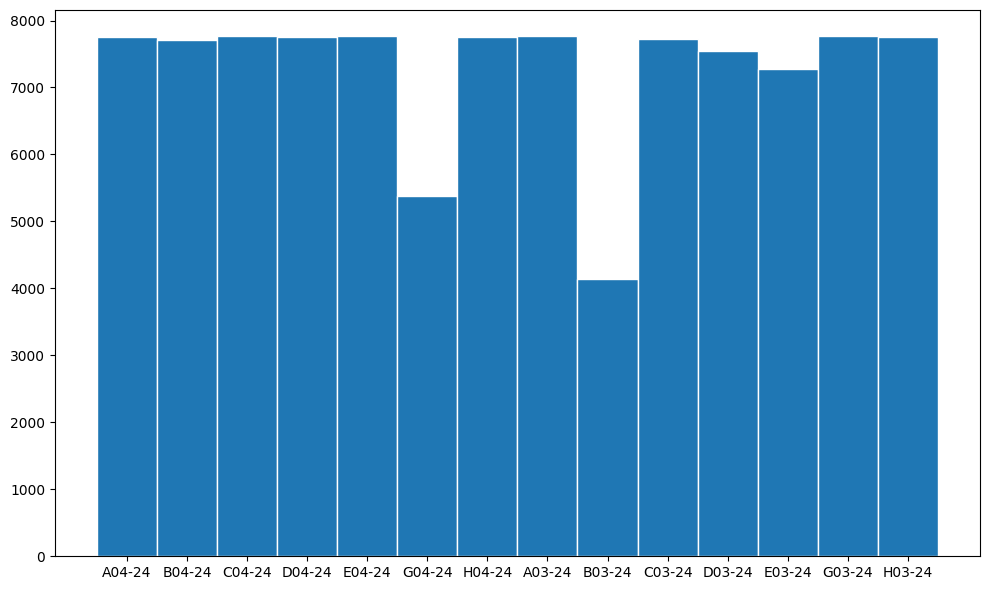

In [723]:

fig,ax = plt.subplots(figsize=(10,6))

x = carteira_df.index

y = carteira_df['demanda']


ax.bar(x,y, width=1 , edgecolor = 'white')



fig.tight_layout()

plt.show()



